In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from Triangulacion import GeneraPoligono

# Vigilancia de la Galería de Arte

Supongamos una galería que debe vigilar diferentes obras de arte distribuídas espacialmente dentro de una construcción que puede asumirse como un polígono simple  

     x  y
0    0  0
1    0 -5
2    3 -7
3    0 -9
4    5 -9
5    7 -7
6    7 -9
7   12 -9
8   12 -6
9   14 -6
10  14 -9
11  16 -7
12  14 -3
13   8 -3
14   6 -1
15   5 -3
16   6 -3
17   7 -4
18   3 -5
19   0  0


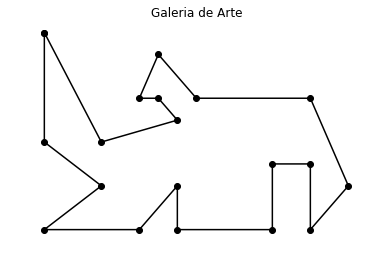

In [2]:
#construye un polígono arbitrario
df = GeneraPoligono()
#df = generapoligono()
print df
plt.scatter(df["x"], df["y"], c="k")
plt.plot(df["x"], df["y"],c="k")
plt.title("Galeria de Arte")
plt.axis("off")
plt.show()

In [ ]:
points = np.random.randint(-10, 0, size=(10, 2)) *np.random.rand(10,2)
d={'x':[round(pts, 1) for pts in points[0:,0]], 'y':[round(pts, 1) for pts in points[0:,1]]}
#pts = cv.convexHull(points)
mts = pd.DataFrame(d,columns=['x', 'y'])
mts


In [70]:
def generapoligono():
    pts = [[0,0], [-4,-3], [-2,-5], [-6, -7], [-1, -14], [4,-10], [2,-10], [3, -6], [7, -14], [11, -6], [14, -9], [16, -5], [19, -3], [17, 4], [6, -1], [8, -4], [0,-4], [0,0]]
    df = pd.DataFrame.from_records(pts, columns = ["x","y"])
    return df

La galería busca colocar cámaras (**fijas y con posibilidad de rotación**) para vigilar las obras buscando que:

* **Las cámaras permitan visualizar cada espacio de la galería (no debe haber puntos ciegos)**.
* **La cantidad de cámaras sea mínima**

# Triangulación

* Si el **polígono** fuera **convexo**, sería suficiente con colocar una cámara para vigilarlo por completo, sin embargo, para polígonos más generales debemos utilizar más cámaras 

* Para resolver el problema, una **primera estrategia**  consiste en considerar que la galería es un polígono simple, **dividir dicho polígono con un conjunto de triángulos** y colocar una cámara en cada uno de los triángulos. 
* <font color="red">Los triángulos se construyen dibujando **diagonales** entre dos vértices diferentes **sin cortar algún lado del polígono**</font> 

**¿Cuántas cámaras son necesarias con esta estrategia?**



In [3]:
#triangulación de los puntos del polígono
deltri = Delaunay(df.values) #algoritmo de triangulación de Delaunay
print df.values

[[ 0  0]
 [ 0 -5]
 [ 3 -7]
 [ 0 -9]
 [ 5 -9]
 [ 7 -7]
 [ 7 -9]
 [12 -9]
 [12 -6]
 [14 -6]
 [14 -9]
 [16 -7]
 [14 -3]
 [ 8 -3]
 [ 6 -1]
 [ 5 -3]
 [ 6 -3]
 [ 7 -4]
 [ 3 -5]
 [ 0  0]]


In [4]:
#el resultado más importante de este algoritmo es
#una matriz con la relación de los índices de los vértices 
#que componen cada triángulo:
deltri.simplices

array([[ 1, 18,  0],
       [14, 13, 12],
       [15, 18, 17],
       [18, 15,  0],
       [15, 14,  0],
       [13,  8, 12],
       [ 8, 13, 17],
       [ 4,  2,  3],
       [ 2,  1,  3],
       [ 1,  2, 18],
       [13, 16, 17],
       [16, 13, 14],
       [16, 15, 17],
       [15, 16, 14],
       [ 9, 10, 11],
       [12,  9, 11],
       [ 8,  9, 12],
       [ 5,  8, 17],
       [ 5,  4,  6],
       [ 7,  5,  6],
       [ 5,  7,  8],
       [ 5,  2,  4],
       [18,  5, 17],
       [ 2,  5, 18],
       [ 9,  7, 10],
       [ 7,  9,  8]], dtype=int32)

In [5]:
def dettria(delatri, df):
    ls = []
    for sec in delatri.simplices:
        ind = list(sec)
        ind.sort()
        a = np.array([[df.loc[ind[0]]['x'],df.loc[ind[0]]['y'], 1], 
                      [df.loc[ind[1]]['x'],df.loc[ind[1]]['y'], 1], 
                      [df.loc[ind[2]]['x'],df.loc[ind[2]]['y'], 1] ])
        det = np.linalg.det(a)
        if det > 0:
            ls.append(list(sec))
    return ls

 ############################################################################

In [29]:
def calculasegs(df):   
    # Segmentos
    segs = pd.DataFrame(columns=['id', 'x1', 'y1', 'x2', 'y2'])
    # Se determina los segmentos que componen al Poligono
    n = len(df)-1
    for i, ev in df.iterrows():
        if i != n:
            sg = 0 if i==n-1 else i+1
            d = {'id':[i,sg], 'x1':ev['x'], 'y1':ev['y'], 'x2':df.loc[sg]['x'], 'y2':df.loc[sg]['y']}
            segs = segs.append(d, ignore_index=True, sort=False)
    # Definir los datos de los segmentos correctamente para tener sentido en las consultas
    segs["x_inf"] = np.where(segs["y1"]>segs["y2"], segs["x2"], segs["x1"])
    segs["y_inf"] = np.where(segs["y1"]>segs["y2"], segs["y2"], segs["y1"])
    segs["x_sup"] = np.where(segs["y1"]>segs["y2"], segs["x1"], segs["x2"])
    segs["y_sup"] = np.where(segs["y1"]>segs["y2"], segs["y1"], segs["y2"])
    segs["domin"] = np.where(segs["x1"]>segs["x2"], segs["x2"], segs["x1"] ) #Definir Dominio
    segs["domax"] = np.where(segs["x1"]>segs["x2"], segs["x1"], segs["x2"] )
    return segs

In [30]:
def calculacentrogravedad(delatri):
    # Centro de Gravedad
    cnt = pd.DataFrame(columns=['it', 'x', 'y'])
    # Se determina el Centro de Gravedad de cada Triángulo
    for i, sec in enumerate(delatri.simplices):
        tr = pd.DataFrame(columns=['i','x','y'])
        for ev in sec:
            d = {'i':ev, 'x':df.loc[ev]['x'], 'y':df.loc[ev]['y']}
            tr= tr.append(d, ignore_index=True, sort=False)
        # La fórmula usada para realizar el cálculo es obtener el promedio de las coordenadas (x,y) de los 3 puntos
        d = { 'it':int(i), 'x':tr['x'].mean(), 'y':tr['y'].mean() }
        cnt = cnt.append(d, ignore_index=True, sort=False)
    return cnt

In [31]:
def determinatriangulos(delatri, df):
    segs = calculasegs(df)
    cnt = calculacentrogravedad(delatri)
    # Definir Triángulos Interiores
    ls = []
    ctf = pd.DataFrame(columns=['it', 'x', 'y'])
    for i, ev in cnt.iterrows():
        # Delimitamos los segmentos ya sea que tengan el rango mínimo o máximo menor al centroide
        q = '(((y_inf>' + str(ev['y']) + ')|(y_sup>' + str(ev['y']) + '))&'
        # Delimitamos que el centroide se encuentre entre el dominio de los segmentos
        q = q + '((domin<' + str(ev['x']) + ')&(domax>' + str(ev['x']) + ')))'
        # Al delimitar no obtenemos como tal los segmentos inferiores o superiores respecto al centroide
        qr = segs.query(q)
        # Por lo que debemos realizar el cálculo de la pendiente (m) y el punto de intercepción en la ordenada (b)
        qr["m"] = (qr["y_sup"]-qr["y_inf"])/(qr["x_sup"]-qr["x_inf"])
        qr["b"] = qr["y_sup"]-qr["m"]*qr["x_sup"]
        # Realizamos el cálculo de 'y' sobre los segmentos anteriormente definidos con la coordenada 'x' dada
        qr['pi'] = ev['x']*qr['m']+qr['b']
        # Realizamos otra consulta pero esta vez nos quedamos con los puntos de intersección que son superiores
        # a la coordenada 'y' del centroide
        q = 'pi>' + str(ev['y'])
        qr = qr.query(q)
        if not qr.empty:
            if (len(qr) % 2) == 1:
                # Si el número de intersecciones es un número impar, guardamos la información
                ls.append(list(delatri.simplices[i]))
                d = { 'it':int(i), 'x':ev['x'], 'y':ev['y'] }
                ctf = ctf.append(d, ignore_index=True, sort=False)
    return {'tri':ls,'cengra':ctf}

In [32]:
def matrizadyacencia(tri):
    n = len(tri)
    # Creamos una matriz con ceros de tamaño 'n x n'
    ady = np.zeros((n, n), dtype=int)
    # Verificamos todos las adyacencias del grafo
    for i, arr in enumerate(tri):
        j = i + 1
        # Se determina el triángulo actual con todos los siguientes en la lista
        for ar in tri[i+1:]:
            c = 0
            # Se determina si al menos los triangulos a evaluar tiene al menos dos vertices en común
            for k in arr:
                 if k in ar:
                    c+= 1
            # Si se cumple la condición entonces se guarda la adyacencia con el valor 1 en las posiciones actuales
            if c == 2:
                ady[i][j]=1
                ady[j][i]=1
            j+=1
    return ady

In [33]:
def listadyacencia(ls):
    # Se crea un conjunto que contiene como información la lista de adyancecia dado un nodo del grafo
    lsady = set()
    for i, l in enumerate(ls):
        if l == 1:
            lsady.add(i)
    return lsady

In [34]:
def definecolorvertices(trian, ver):
    # Se crea un conjunto con la lista de los colores disponibles [ Modificable ]
    c = set(['r', 'g', 'b'])
    vp = set() # Conjunto vacío que representa los vertices que ya han sido pintados con anterioridad (Vertices Pintados)
    lv = [] # Lista vacía de los vertices por pintar
    # Se determina cada punto del triángulo para verificar si ya ha sido pintado con anterioridad
    for ev in trian:
        # Se realiza la consulta en 'ver', ya que es un DF que contiene la información de coloración de los vertices
        q = 'i==' + str(ev) 
        a = ver.query(q)
        a.reset_index(drop=True, inplace=True)
        if a.empty:
            # Si no se encontró el vertice en el DF se guarda en la lista de los vertices por pintar
            lv.append(ev)
        else:
            # Si se encontró el vertices entonces se guarda el color en el conjunto
            vp.add(a.loc[0]['c'])
    # Se realiza el lista de la diferencia del conjunto de colores respecto a los vertices ya pintados
    # Con está operación siempre obtenemos el color restante
    lc = list(c.difference(vp))
    #lc = list(c - vp)  # Equivalente a la instrucción de la linea anterior
    # Ahora se agregan los vertices por pintar al DF con su respectivo color
    for i, v in enumerate(lv):
        d = {'i':v,'c':str(lc[i])}
        ver = ver.append(d, ignore_index=True, sort=False)
    # Dado la simplificación del algoritmo y la utilidad del grafo, la primera vez que se ejecuta esta rutina
    # se guardan los tres vertices, pero apartir de la siguiente vez que se use debido a la adyancecia
    # solo se agrega color al vertice faltante
    return ver

In [35]:
def DFS(graph, tri, start):
    # Aplicación del Algoritmo 'Búsqueda en Profundidad' o 'Deep First Search' 
    ver = pd.DataFrame(columns=['i', 'c'])
    stack = [start]
    visited = set()
    while stack:
        vertex = stack.pop()
        if not vertex in visited:
            visited.add(vertex)
            stack.extend((listadyacencia(graph[vertex])).difference(visited))
            #stack.extend(listadyacencia(graph[vertex]) - visited) # Equivalente a la instrucción de la linea anterior
            # Modificación en el DFS para obtener un DF que contiene la coloración de los vertices
            ver = definecolorvertices(tri[vertex], ver)
    ver = ver.sort_values(by=["i"], ascending=True)
    ver.reset_index(drop=True, inplace=True)
    d = {'i':len(ver), 'c':ver.loc[0]['c']}
    ver = ver.append(d, ignore_index=True, sort=False)
    return ver

In [36]:
def coloreavertices(df):
    # Copia de DF de vertices
    cam = df.copy(deep=True)
    #triangulación de los puntos del polígono
    delatri = Delaunay(df.values) #algoritmo de triangulación de Delaunay
    # Determina triangulos internos
    trian = determinatriangulos(delatri, df)
    # Crea Grafo (Matriz de Adyacencia)
    ady = matrizadyacencia(trian['tri'])
    # Recorrido de Grafo y asignación de colores a vertices
    col = DFS(ady, trian['tri'], 0)
    # Asignación de colores al DF de vertices
    cam['c'] = col['c']
    return {'cam':cam, 'tri':{'trian':trian['tri'], 'cengra':trian['cengra']} }

In [37]:
def dibujapoligono(df, trian, show=True):
    #Dibuja cada uno de los triángulos
    plt.title("Galeria de Arte")
    plt.axis("off")
    for t in trian['trian']:
        #la rutina triangula los puntos del polígono, formando un polígono convexo, 
        plt.plot([df.iloc[t[0]]["x"],df.iloc[t[1]]["x"],df.iloc[t[2]]["x"]], 
                 [df.iloc[t[0]]["y"],df.iloc[t[1]]["y"],df.iloc[t[2]]["y"]], "r:")
    # Dibuja los puntos con su respectivo color
    plt.scatter(df["x"], df["y"], c=df['c'])
    # [ Opcional ] Dibuja los centroides de cada triángulo
    #plt.scatter(trian['cengra']['x'], trian['cengra']['y'], marker='X', c='k')
    plt.plot(df["x"], df["y"], c='k')
    if show:
        plt.show()

In [23]:
vertices = coloreavertices(df)

/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

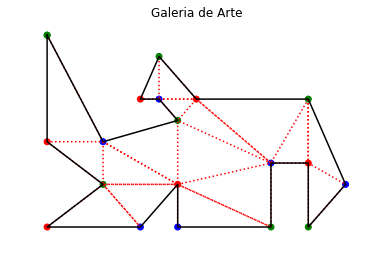

In [28]:
dibujapoligono(vertices['cam'], vertices['tri'])

/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

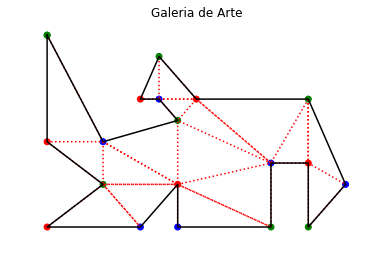

In [2]:
from Triangulacion import GeneraPoligono
# Importar Librerías
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
%matplotlib inline

def calculasegs(df):   
    # Segmentos
    segs = pd.DataFrame(columns=['id', 'x1', 'y1', 'x2', 'y2'])
    # Se determina los segmentos que componen al Poligono
    n = len(df)-1
    for i, ev in df.iterrows():
        if i != n:
            sg = 0 if i==n-1 else i+1
            d = {'id':[i,sg], 'x1':ev['x'], 'y1':ev['y'], 'x2':df.loc[sg]['x'], 'y2':df.loc[sg]['y']}
            segs = segs.append(d, ignore_index=True, sort=False)
    # Definir los datos de los segmentos correctamente para tener sentido en las consultas
    segs["x_inf"] = np.where(segs["y1"]>segs["y2"], segs["x2"], segs["x1"])
    segs["y_inf"] = np.where(segs["y1"]>segs["y2"], segs["y2"], segs["y1"])
    segs["x_sup"] = np.where(segs["y1"]>segs["y2"], segs["x1"], segs["x2"])
    segs["y_sup"] = np.where(segs["y1"]>segs["y2"], segs["y1"], segs["y2"])
    segs["domin"] = np.where(segs["x1"]>segs["x2"], segs["x2"], segs["x1"] ) #Definir Dominio
    segs["domax"] = np.where(segs["x1"]>segs["x2"], segs["x1"], segs["x2"] )
    return segs

def calculacentrogravedad(delatri):
    # Centro de Gravedad
    cnt = pd.DataFrame(columns=['it', 'x', 'y'])
    # Se determina el Centro de Gravedad de cada Triángulo
    for i, sec in enumerate(delatri.simplices):
        tr = pd.DataFrame(columns=['i','x','y'])
        for ev in sec:
            d = {'i':ev, 'x':df.loc[ev]['x'], 'y':df.loc[ev]['y']}
            tr= tr.append(d, ignore_index=True, sort=False)
        # La fórmula usada para realizar el cálculo es obtener el promedio de las coordenadas (x,y) de los 3 puntos
        d = { 'it':int(i), 'x':tr['x'].mean(), 'y':tr['y'].mean() }
        cnt = cnt.append(d, ignore_index=True, sort=False)
    return cnt

def determinatriangulos(delatri, df):
    segs = calculasegs(df)
    cnt = calculacentrogravedad(delatri)
    # Definir Triángulos Interiores
    ls = []
    ctf = pd.DataFrame(columns=['it', 'x', 'y'])
    for i, ev in cnt.iterrows():
        # Delimitamos los segmentos ya sea que tengan el rango mínimo o máximo menor al centroide
        q = '(((y_inf>' + str(ev['y']) + ')|(y_sup>' + str(ev['y']) + '))&'
        # Delimitamos que el centroide se encuentre entre el dominio de los segmentos
        q = q + '((domin<' + str(ev['x']) + ')&(domax>' + str(ev['x']) + ')))'
        # Al delimitar no obtenemos como tal los segmentos inferiores o superiores respecto al centroide
        qr = segs.query(q)
        # Por lo que debemos realizar el cálculo de la pendiente (m) y el punto de intercepción en la ordenada (b)
        qr["m"] = (qr["y_sup"]-qr["y_inf"])/(qr["x_sup"]-qr["x_inf"])
        qr["b"] = qr["y_sup"]-qr["m"]*qr["x_sup"]
        # Realizamos el cálculo de 'y' sobre los segmentos anteriormente definidos con la coordenada 'x' dada
        qr['pi'] = ev['x']*qr['m']+qr['b']
        # Realizamos otra consulta pero esta vez nos quedamos con los puntos de intersección que son superiores
        # a la coordenada 'y' del centroide
        q = 'pi>' + str(ev['y'])
        qr = qr.query(q)
        if not qr.empty:
            if (len(qr) % 2) == 1:
                # Si el número de intersecciones es un número impar, guardamos la información
                ls.append(list(delatri.simplices[i]))
                d = { 'it':int(i), 'x':ev['x'], 'y':ev['y'] }
                ctf = ctf.append(d, ignore_index=True, sort=False)
    return {'tri':ls,'cengra':ctf}

def matrizadyacencia(tri):
    n = len(tri)
    # Creamos una matriz con ceros de tamaño 'n x n'
    ady = np.zeros((n, n), dtype=int)
    # Verificamos todos las adyacencias del grafo
    for i, arr in enumerate(tri):
        j = i + 1
        # Se determina el triángulo actual con todos los siguientes en la lista
        for ar in tri[i+1:]:
            c = 0
            # Se determina si al menos los triangulos a evaluar tiene al menos dos vertices en común
            for k in arr:
                 if k in ar:
                    c+= 1
            # Si se cumple la condición entonces se guarda la adyacencia con el valor 1 en las posiciones actuales
            if c == 2:
                ady[i][j]=1
                ady[j][i]=1
            j+=1
    return ady

def listadyacencia(ls):
    # Se crea un conjunto que contiene como información la lista de adyancecia dado un nodo del grafo
    lsady = set()
    for i, l in enumerate(ls):
        if l == 1:
            lsady.add(i)
    return lsady

def definecolorvertices(trian, ver):
    # Se crea un conjunto con la lista de los colores disponibles [ Modificable ]
    c = set(['r', 'g', 'b'])
    vp = set() # Conjunto vacío que representa los vertices que ya han sido pintados con anterioridad (Vertices Pintados)
    lv = [] # Lista vacía de los vertices por pintar
    # Se determina cada punto del triángulo para verificar si ya ha sido pintado con anterioridad
    for ev in trian:
        # Se realiza la consulta en 'ver', ya que es un DF que contiene la información de coloración de los vertices
        q = 'i==' + str(ev) 
        a = ver.query(q)
        a.reset_index(drop=True, inplace=True)
        if a.empty:
            # Si no se encontró el vertice en el DF se guarda en la lista de los vertices por pintar
            lv.append(ev)
        else:
            # Si se encontró el vertices entonces se guarda el color en el conjunto
            vp.add(a.loc[0]['c'])
    # Se realiza el lista de la diferencia del conjunto de colores respecto a los vertices ya pintados
    # Con está operación siempre obtenemos el color restante
    lc = list(c.difference(vp))
    #lc = list(c - vp)  # Equivalente a la instrucción de la linea anterior
    # Ahora se agregan los vertices por pintar al DF con su respectivo color
    for i, v in enumerate(lv):
        d = {'i':v,'c':str(lc[i])}
        ver = ver.append(d, ignore_index=True, sort=False)
    # Dado la simplificación del algoritmo y la utilidad del grafo, la primera vez que se ejecuta esta rutina
    # se guardan los tres vertices, pero apartir de la siguiente vez que se use debido a la adyancecia
    # solo se agrega color al vertice faltante
    return ver

def DFS(graph, tri, start):
    # Aplicación del Algoritmo 'Búsqueda en Profundidad' o 'Deep First Search' 
    ver = pd.DataFrame(columns=['i', 'c'])
    stack = [start]
    visited = set()
    while stack:
        vertex = stack.pop()
        if not vertex in visited:
            visited.add(vertex)
            stack.extend((listadyacencia(graph[vertex])).difference(visited))
            #stack.extend(listadyacencia(graph[vertex]) - visited) # Equivalente a la instrucción de la linea anterior
            # Modificación en el DFS para obtener un DF que contiene la coloración de los vertices
            ver = definecolorvertices(tri[vertex], ver)
    ver = ver.sort_values(by=["i"], ascending=True)
    ver.reset_index(drop=True, inplace=True)
    d = {'i':len(ver), 'c':ver.loc[0]['c']}
    ver = ver.append(d, ignore_index=True, sort=False)
    return ver

def coloreavertices(df):
    # Copia de DF de vertices
    cam = df.copy(deep=True)
    #triangulación de los puntos del polígono
    delatri = Delaunay(df.values) #algoritmo de triangulación de Delaunay
    # Determina triangulos internos
    trian = determinatriangulos(delatri, df)
    # Crea Grafo (Matriz de Adyacencia)
    ady = matrizadyacencia(trian['tri'])
    # Recorrido de Grafo y asignación de colores a vertices
    col = DFS(ady, trian['tri'], 0)
    # Asignación de colores al DF de vertices
    cam['c'] = col['c']
    return {'cam':cam, 'tri':{'trian':trian['tri'], 'cengra':trian['cengra']} }

def dibujapoligono(df, trian, show=True):
    #Dibuja cada uno de los triángulos
    plt.title("Galeria de Arte")
    plt.axis("off")
    for t in trian['trian']:
        #la rutina triangula los puntos del polígono, formando un polígono convexo, 
        plt.plot([df.iloc[t[0]]["x"],df.iloc[t[1]]["x"],df.iloc[t[2]]["x"]], 
                 [df.iloc[t[0]]["y"],df.iloc[t[1]]["y"],df.iloc[t[2]]["y"]], "r:")
    # Dibuja los puntos con su respectivo color
    plt.scatter(df["x"], df["y"], c=df['c'])
    # [ Opcional ] Dibuja los centroides de cada triángulo
    #plt.scatter(trian['cengra']['x'], trian['cengra']['y'], marker='X', c='k')
    plt.plot(df["x"], df["y"], c='k')
    if show:
        plt.show()

df = GeneraPoligono()
vertices = coloreavertices(df)
dibujapoligono(vertices['cam'], vertices['tri'])

In [92]:
tri = determinatriangulos(deltri, df)
print tri

/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

{'tri': [[1, 18, 0], [13, 8, 12], [8, 13, 17], [4, 2, 3], [1, 2, 18], [13, 16, 17], [16, 13, 14], [15, 16, 14], [9, 10, 11], [12, 9, 11], [8, 9, 12], [5, 8, 17], [7, 5, 6], [5, 7, 8], [5, 2, 4], [18, 5, 17], [2, 5, 18]], 'cengra':       it          x         y
0    0.0   1.000000 -3.333333
1    5.0  11.333333 -4.000000
2    6.0   9.000000 -4.333333
3    7.0   2.666667 -8.333333
4    9.0   2.000000 -5.666667
5   10.0   7.000000 -3.333333
6   11.0   6.666667 -2.333333
7   13.0   5.666667 -2.333333
8   14.0  14.666667 -7.333333
9   15.0  14.666667 -5.333333
10  16.0  13.333333 -5.000000
11  17.0   8.666667 -5.666667
12  19.0   8.666667 -8.333333
13  20.0  10.333333 -7.333333
14  21.0   5.000000 -7.666667
15  22.0   5.666667 -5.333333
16  23.0   4.333333 -6.333333}


In [16]:
ady = matrizadyacencia(tri)
print ady

[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0]]


In [17]:
col = DFS(ady, tri, 0)
cam = df.copy(deep=True)
print col
#q = cam.head(len(cam)-1).query("c=='g'")
#print len(q)
cam

     i  c
0    0  g
1    1  r
2    2  g
3    3  r
4    4  b
5    5  r
6    6  b
7    7  g
8    8  b
9    9  r
10  10  g
11  11  b
12  12  g
13  13  r
14  14  g
15  15  r
16  16  b
17  17  g
18  18  b
19  19  g


,x,y
0,0,0
1,0,-5
2,3,-7
3,0,-9
4,5,-9
5,7,-7
6,7,-9
7,12,-9
8,12,-6
9,14,-6


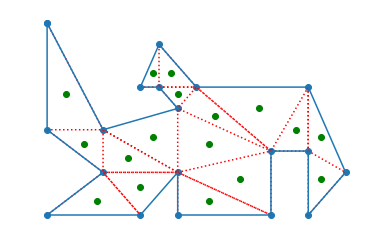

In [94]:
#dibuja cada uno de los triángulos
for t in tri['tri']:
    #if not i in (1,2,3,4,8,12,18,24,25): #la rutina triangula los puntos del polígono, formando un polígono convexo, esa condición elimina los triángulos externos al polígono
    #if not i in (8,2,3,4,1,18,24,25,12): #la rutina triangula los puntos del polígono, formando un polígono convexo, esa condición elimina los triángulos externos al polígono
    plt.plot([df.iloc[t[0]]["x"],df.iloc[t[1]]["x"],df.iloc[t[2]]["x"]], [df.iloc[t[0]]["y"],df.iloc[t[1]]["y"],df.iloc[t[2]]["y"]], "r:")
plt.scatter(df["x"], df["y"])
plt.scatter(ctf["x"], ctf["y"], c='g')
plt.plot(df["x"], df["y"])
plt.axis("off")
plt.show()

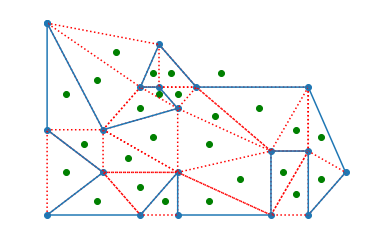

In [97]:
#dibuja cada uno de los triángulos
for i, t in enumerate(deltri.simplices):
    #if not i in (1,2,3,4,8,12,18,24,25): #la rutina triangula los puntos del polígono, formando un polígono convexo, esa condición elimina los triángulos externos al polígono
    #if not i in (8,2,3,4,1,18,24,25,12): #la rutina triangula los puntos del polígono, formando un polígono convexo, esa condición elimina los triángulos externos al polígono
        
    plt.plot([df.iloc[t[0]]["x"],df.iloc[t[1]]["x"],df.iloc[t[2]]["x"]], [df.iloc[t[0]]["y"],df.iloc[t[1]]["y"],df.iloc[t[2]]["y"]], "r:")
plt.scatter(df["x"], df["y"])
plt.scatter(cnt["x"], cnt["y"], c='g')
plt.plot(df["x"], df["y"])
plt.axis("off")
plt.show()

In [57]:
print deltri.simplices

[[ 1 18  0]
 [14 13 12]
 [15 18 17]
 [18 15  0]
 [15 14  0]
 [13  8 12]
 [ 8 13 17]
 [ 4  2  3]
 [ 2  1  3]
 [ 1  2 18]
 [13 16 17]
 [16 13 14]
 [16 15 17]
 [15 16 14]
 [ 9 10 11]
 [12  9 11]
 [ 8  9 12]
 [ 5  8 17]
 [ 5  4  6]
 [ 7  5  6]
 [ 5  7  8]
 [ 5  2  4]
 [18  5 17]
 [ 2  5 18]
 [ 9  7 10]
 [ 7  9  8]]


In [ ]:
dfs(ady, tri, 0)

In [ ]:
#dfs(ady, 0)
c = set(['r', 'g', 'b'])
list(c)[0]

In [ ]:
ver = pd.DataFrame(columns=['i', 'c'])
ver

In [ ]:
defcolvert([1, 18, 0], ver)
#colvert([1, 2, 18], ver)

In [ ]:
ver = ver.append({'i':1,'c':'r'}, ignore_index=True, sort=False)
ver = ver.append({'i':18,'c':'g'}, ignore_index=True, sort=False)
ver = ver.append({'i':0,'c':'b'}, ignore_index=True, sort=False)
ver

In [ ]:
getady(ady[0])

Al colocar una cámara en cada triángulo, serían necesarias $n-2$ cámaras, dado que 

*Un polígono simple con $n$ vértices puede subdividirse en $n-2$ triángulos*

## Demostración

La demostración puede realizarse por inducción

1. **Caso base** ($n = 3$)
    2. Considera un triángulo (polígono simple) para el que $n = 3$. Dicho polígno puede subdividirse en $n-2=1$ triángulos.
2. **Generalización** Para un polígono con $n$ vértices
    3. Suponemos que cualquier polígono con $m < n$ vértices puede subdividirse en $m-2$ triángulos.
    4. **Si fuera posible** dibujar alguna diagonal entre dos vértices diferentes en el polígono con $n$ vértices, este quedaría dividido en dos polígonos simples con $m_1$ y $m_2$ lados
        5. $m_1 < n$ y $m_2 < n$. 
        6. $m_1+m_2-2=n$
    5. Cada uno de esos polígono puede dividirse por $m_1-2$ y $m_2-2$ triángulos, por lo que al unirlos, el polígono original se dividiría en $(m_1-2)+(m_2-2)=(m_1+m_2)-4=(n+2)-4=n-2$ triángulos 
    
Para terminar la demostración deberíamos mostrar que **siempre es posible dividir un polígono simple** en dos polígonos simples mediante una diagonal

## Una cota aún menor para el número de cámaras

Colocar una cámara en cada triángulo es una estrategia ineficiente. Podemos fácilmente pensar en estrategias diferentes aún mejores.  

**Cámaras en las diagonales**

Una diagonal permite acceder a dos triángulos diferentes, de manera que colocar una cámara en cada una de ellas permite cubrir toda la galería con aproximadamente $\lfloor \frac{n}{2} \rfloor$ cámaras

** Cámaras en vértices **

Podría ser más ventajoso colocar cámaras en algunos vertices del polígono, sobre todo si en esos vértices inciden muchos triángulos.

Podemos vigilar toda la galería si colocamos cámaras en los vértices del polígono, de manera que cada triángulo tenga una cámara en, exactamente, un vértice. Esto se puede realizar guiándonos por el problema de **coloración** de los vértices de los triángulos, de esta manera, el número de cámaras podría reducirse a $\lfloor \frac{n}{3} \rfloor$

## Coloración de los vértices de los triángulos

Buscamos asignar uno de tres colores (negro, blanco y gris) a cada uno de los vértices de los triángulos cuidando que los vértices de cada triángulo tengan los tres colores diferentes

<img src="coloracion.png" />

Resolver el problema es posible si consideramos la representación de la triangulación mediante la **gráfica dual** de la triangulación. En esta gráfica dual

1. Cada triángulo es un nodo.
2. Existe una arista entre dos nodos si los triángulos correspondientes están unidos por una diagonal

<img src="dual_graph.png" />

La gráfica en particular es un **árbol**

* Observa que los nodos están mínimamente conectados

Puedes colorear los triángulos coloreando los vértices del triángulo asociado a alguna hoja [seleccioanda arbitrariamente] y extender la coloración a los nodos vecinos. 

* Observa que si un triángulo ha sido coloreado, el triángulo vecino ya tiene dos vértices coloreados y resta colorear solo uno (con el color complementario)

# <font color="red">Tarea</font>

**Objetivo**: Realizar la coloración de los vértices de un polígono general.

**Instrucciones:**

Para desarrollar este proyecto, deben considerar que el polígono está definido de la siguiente manera: 

1. Las coordenadas de los vértices están registradas en un DataFrame con las columnas *x* e *y*.
2. El polígono contiene un número arbitrario de vértices y se construye uniendo con líneas los vértices sucesivos del DataFrame.
3. El polígono debe leerse por medio de una función llamada $\texttt{GeneraPolígono}$, que no recibe parámetros, pero que les regresa el DataFrame [como la utilizada en esta libreta]. 

Para un **polígono arbitrario** construido con la función $\texttt{GeneraPolígono}$, su implementación debe realizar lo siguiente:

1. Triangular los vértices del polígono mediante el algoritmo de Delaunay.
2. Construir una función que identifique si un triángulo, definido por sus tres vértices se encuentra fuera del polígono original.
3. Eliminar de la triangulación de Delaunay los triángulos ubicados fuera del polígono original.
4. Aplicar la estrategia de coloración de vértices definida en la sección anterior, utilizando tres colores diferentes [ustedes pueden seleccionarlos arbitrariamente]
5. Mostrar, en una gráfica:
    5. El polígono original 
    5. Los vértices coloreados.
    5. Los triángulos internos obtenidos del algoritmo de Delaunay. 

** Consideraciones para revisión**

El polígono que se genera al inicio de esta libreta puede servirles como caso base, aunque les sugiero asegurarse que su implementación funcione correctamente probando con otros casos, generados de forma aleatoria preferentemente [es la estrategia que seguiré para revisar su proyecto].

Deben enviar una libreta con su implementación, la cual debe contener una sola celda de código, de manera que yo pueda revisar su proyecto ejecutando dicha celda. La primera instrucción de la celda debe ser la siguiente:

$$\texttt{from Triangulacion import GeneraPoligono}$$

Para probar yo integraré mi implementación de la función $\texttt{GeneraPoligono}$ que generará polígonos arbitrarios.

Sus implementaciones serán revisadas con software especializado en la detección de plagios.

Pueden pasar a mi cubículo para discutir dudas.

**Entrega:**

Viernes 7 de marzo [entregas fuera de tiempo tiempo tendrán un factor de penalización del $40\%$].